In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima.model import ARIMA
from pandas.tseries.offsets import DateOffset

In [128]:
# Load the data
df = pd.read_csv('../data/curated/historical_data.csv')
df

,type,suburb,Count,Date,Median,year_completed,sa2_name,sa2_code,Unnamed: 0,SA2_CODE,Population,percentage_change_rental_price,percentage_change_population
0,1 bedroom flat,Altona,87.0,2000-03-01,95.0,2000,Altona,213021341,930,213021341,12297.095890,NaN,NaN
1,1 bedroom flat,Altona,94.0,2000-06-01,100.0,2000,Altona,213021341,1452,213021341,12271.915068,0.052632,-0.002048
2,1 bedroom flat,Altona,97.0,2000-09-01,105.0,2000,Altona,213021341,1974,213021341,12246.457534,0.050000,-0.002074
3,1 bedroom flat,Altona,98.0,2000-12-01,105.0,2000,Altona,213021341,2496,213021341,12221.000000,0.000000,-0.002079
4,1 bedroom flat,Altona,89.0,2001-03-01,105.0,2001,Altona,213021341,3018,213021341,12196.095890,0.000000,-0.002038
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29619,All properties,Wodonga,1233.0,2022-03-01,380.0,2022,Wodonga,204031492,46538,204031492,14863.726027,0.027027,-0.001094
29620,All properties,Wodonga,1267.0,2022-06-01,390.0,2022,Wodonga,204031492,47060,204031492,14847.271233,0.026316,-0.001107
29621,All properties,Wodonga,1251.0,2022-09-01,400.0,2022,Wodonga,204031492,47582,204031492,14830.635616,0.025641,-0.001120
29622,All properties,Wodonga,1191.0,2022-12-01,410.0,2022,Wodonga,204031492,48104,204031492,14814.000000,0.025000,-0.001122


In [129]:
df['Date'] = pd.to_datetime(df['Date'])

In [130]:
def fit_arima(ts_data):
    model = ARIMA(ts_data['Median'], order=(5, 1, 0))
    model_fit = model.fit()
    return model_fit

/Users/dakshagrawal/PycharmProjects/project-2-group-real-estate-industry-project-3/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/dakshagrawal/PycharmProjects/project-2-group-real-estate-industry-project-3/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/dakshagrawal/PycharmProjects/project-2-group-real-estate-industry-project-3/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autor

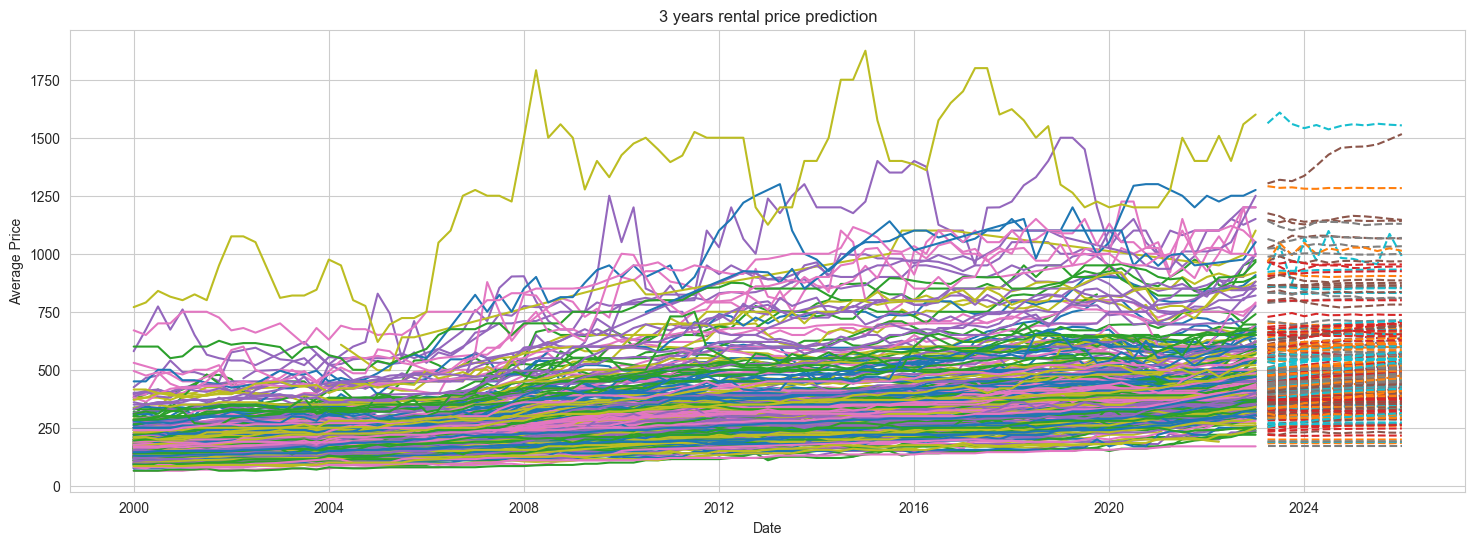

In [131]:
all_predictions = pd.DataFrame()
plt.figure(figsize=(18, 6))

for suburb in df["suburb"].unique():
    for property_type in df["type"].unique():
        try:
            ts_data = df[(df['suburb'] == suburb) & (df['type'] == property_type)]

            ts_data = ts_data[['Date', 'Median']].set_index('Date')
            ts_data['Median'] = pd.to_numeric(ts_data['Median'], errors='coerce')
            ts_data.index = pd.DatetimeIndex(ts_data.index).to_period('Q')

            model = ARIMA(ts_data['Median'], order=(5, 1, 0))
            model_fit = model.fit()

            future_steps = 3 * 4
            forecast = model_fit.forecast(steps=future_steps)

            last_date = ts_data.index[-1]
            if isinstance(last_date, pd.Period):
                last_date = last_date.to_timestamp()
            future_dates = [last_date + DateOffset(months=3 * x) for x in range(1, future_steps + 1)]

            forecast_df = pd.DataFrame({'Date': future_dates, 'Predicted_Median': forecast})
            forecast_df['suburb'] = suburb
            forecast_df['type'] = property_type

            all_predictions = pd.concat([all_predictions, forecast_df])

            forecast_df['Date'] = forecast_df['Date'].to_timestamp()
            ts_data.index = ts_data.index.to_timestamp()

            sns.lineplot(x=ts_data.index, y=ts_data['Median'], label=f'history: {suburb}')
            sns.lineplot(x=forecast_df.index, y=forecast_df['Predicted_Median'], label=f'predicted: {suburb}', linestyle='--')
        except:
            pass
plt.legend().set_visible(False)
plt.title('3 years rental price prediction')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.show()

In [132]:
all_predictions.to_csv('../data/curated/future_rent_prediction.csv', index=False)